In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import catboost as cbt

import datetime

from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import pickle
with open('many_col_names.pkl', 'rb') as f:
    MODEL_FEATURES, CATEGORICAL_FEATURES, roman_feature_names, roman_categorical,\
                all_good_features, all_good_categorical = pickle.load(f)
    
all_df = pd.read_pickle('many_ids_all_features.pkl')

In [6]:
N_TRAIN_EXAMPLES = 590540

In [7]:
N_TRAIN_EXAMPLES = 590540
N_TRAIN = sum(all_df['DT_split'] < 17)

# Splits

In [41]:
subcard_cnt = all_df['subcard_categorical_full'].value_counts()

In [49]:
small_subcard = set(subcard_cnt[subcard_cnt < 20].index)

In [51]:
mask = all_df['subcard_categorical_full'].isin(small_subcard)
all_df.loc[:, 'subcard_categorical_full'][mask] = 99999999

/home/tishur/miniconda3/envs/fraud/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
train_final = all_df[:N_TRAIN_EXAMPLES]
test_final = all_df[N_TRAIN_EXAMPLES:]

tr = train_final[:N_TRAIN]
val = train_final[N_TRAIN:]

In [53]:
def downsample(df, how_strong=2):
    positive = df[df.isFraud == 1]
    negative = df[df.isFraud == 0]
    negative = negative.sample(int(len(negative) / how_strong))
    res = pd.concat([positive, negative])
    return res.sort_values('TransactionDT')

In [54]:
tr = downsample(tr, 5)
val = downsample(val, 5)

In [55]:
tm_features = all_good_features - set(['subcard_categorical'])
tm_categorical = all_good_categorical - set(['subcard_categorical'])

# Train

In [56]:
dtrain = cbt.Pool(tr[tm_features], label=tr['isFraud'],
                     cat_features=tm_categorical)

dval = cbt.Pool(val[tm_features], label=val['isFraud'],
                     cat_features=tm_categorical)

In [57]:
params = {'loss_function': 'Logloss',
          'eval_metric': 'AUC',
          'iterations': 10000,
          'learning_rate': 0.1,
          'model_size_reg': 5.5,
          'random_seed': 11,
          'l2_leaf_reg': 15,
          #'bootstrap_type': 'Bernoulli',
          'bagging_temperature': 1,
          'one_hot_max_size': 8,
          #'ctr_leaf_count_limit': 1000,
          'max_ctr_complexity': 4,
          #'subsample': 0.8,
          'sampling_frequency': 'PerTreeLevel',
          'use_best_model': True,
          'max_depth': 12,
          'grow_policy': 'SymmetricTree',
          'min_data_in_leaf': 1,
          'max_leaves': 31,
          'has_time': False,
          'colsample_bylevel': 0.8,
          'scale_pos_weight': 1,
          'boosting_type': 'Plain',
          'early_stopping_rounds': 30,
          'od_type': 'Iter',
          'max_bin': 254,
          'verbose_eval': 25,
          'feature_border_type': 'GreedyLogSum',
          #'simple_ctr':
          
         }

In [58]:
%%time
model = cbt.CatBoost(params)
model.fit(dtrain, eval_set=dval)

0:	test: 0.8230075	best: 0.8230075 (0)	total: 1.55s	remaining: 4h 18m 14s
25:	test: 0.9158398	best: 0.9158398 (25)	total: 35.2s	remaining: 3h 45m 11s
50:	test: 0.9242216	best: 0.9242216 (50)	total: 1m 10s	remaining: 3h 49m 49s
75:	test: 0.9287949	best: 0.9288358 (74)	total: 1m 45s	remaining: 3h 49m 32s
100:	test: 0.9311282	best: 0.9312433 (98)	total: 2m 20s	remaining: 3h 49m 11s
125:	test: 0.9331482	best: 0.9331482 (125)	total: 2m 54s	remaining: 3h 48m 20s
150:	test: 0.9342762	best: 0.9342762 (150)	total: 3m 29s	remaining: 3h 47m 56s
175:	test: 0.9356926	best: 0.9356926 (175)	total: 4m 4s	remaining: 3h 47m 8s
200:	test: 0.9358883	best: 0.9359362 (192)	total: 4m 38s	remaining: 3h 46m 15s
225:	test: 0.9405274	best: 0.9405274 (225)	total: 5m 12s	remaining: 3h 44m 59s
250:	test: 0.9455667	best: 0.9455667 (250)	total: 5m 47s	remaining: 3h 45m 15s
275:	test: 0.9456700	best: 0.9458071 (264)	total: 6m 22s	remaining: 3h 44m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0

In [39]:
%%time
model = cbt.CatBoost(params)
model.fit(dtrain, eval_set=dval)

0:	test: 0.8149324	best: 0.8149324 (0)	total: 1.42s	remaining: 3h 57m 17s
25:	test: 0.9012519	best: 0.9012519 (25)	total: 35.8s	remaining: 3h 49m 7s
50:	test: 0.9144389	best: 0.9144389 (50)	total: 1m 11s	remaining: 3h 53m 31s
75:	test: 0.9200872	best: 0.9200872 (75)	total: 1m 46s	remaining: 3h 52m 41s
100:	test: 0.9392401	best: 0.9392401 (100)	total: 2m 21s	remaining: 3h 51m 18s
125:	test: 0.9418857	best: 0.9421318 (112)	total: 2m 57s	remaining: 3h 51m 55s
150:	test: 0.9428564	best: 0.9428564 (150)	total: 3m 33s	remaining: 3h 52m 9s
175:	test: 0.9433377	best: 0.9433377 (175)	total: 4m 8s	remaining: 3h 51m 14s
200:	test: 0.9435423	best: 0.9437416 (187)	total: 4m 43s	remaining: 3h 50m 13s
225:	test: 0.9439183	best: 0.9439499 (217)	total: 5m 17s	remaining: 3h 49m 2s
250:	test: 0.9441095	best: 0.9441303 (248)	total: 5m 51s	remaining: 3h 47m 41s
275:	test: 0.9442528	best: 0.9442582 (270)	total: 6m 25s	remaining: 3h 46m 27s
300:	test: 0.9443290	best: 0.9443290 (300)	total: 6m 59s	remaining: 

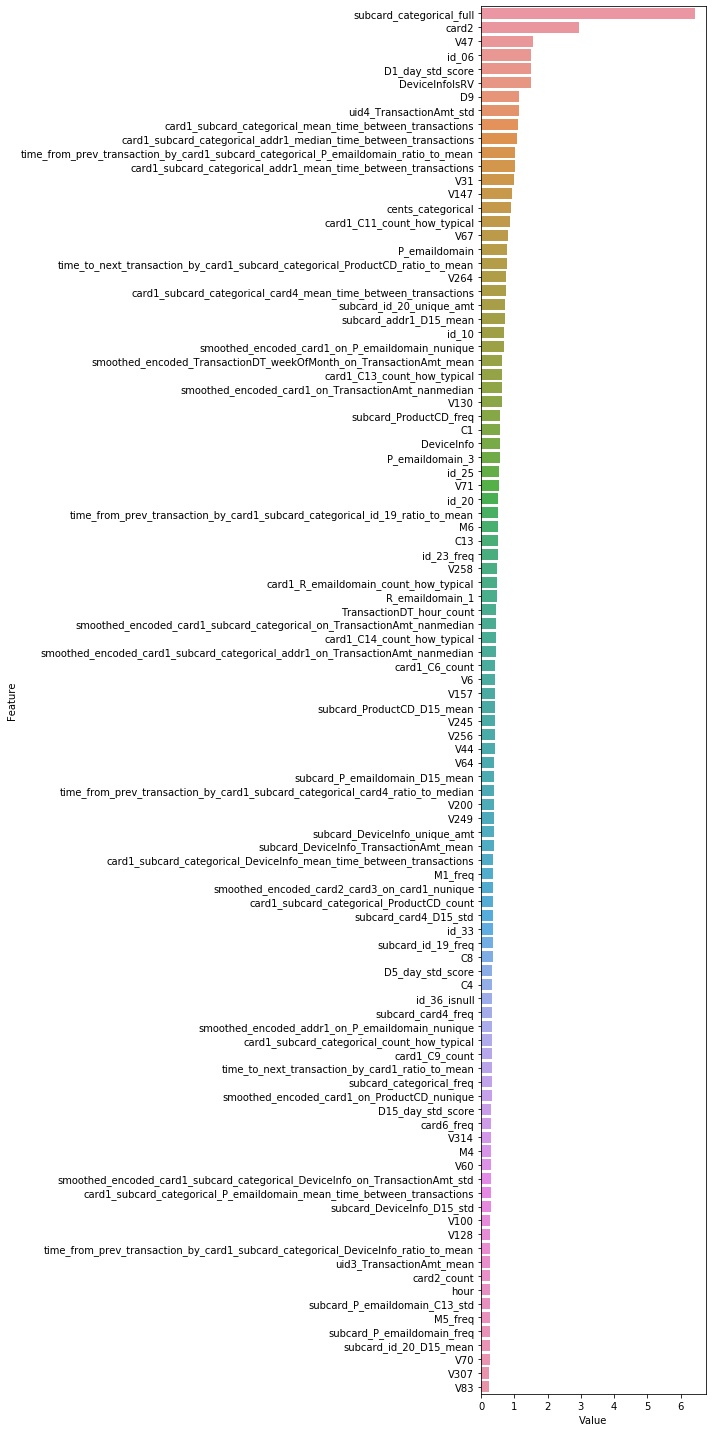

In [40]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, all_good_features)), columns=['Value','Feature'])
bad_cols = feature_imp[feature_imp['Value'] < 1]['Feature']
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:100])
plt.tight_layout()
plt.show()

In [ ]:
preds = model.predict(dval, prediction_type='Probability')

In [ ]:
model.best_score_

# Fit KFold (Scary)

In [13]:
params = {'loss_function': 'Logloss',
          'eval_metric': 'AUC',
          'iterations': 10000,
          'learning_rate': 0.03,
          'model_size_reg': 5.5,
          'random_seed': 11,
          'l2_leaf_reg': 15,
          #'bootstrap_type': 'Bernoulli',
          'bagging_temperature': 1,
          'one_hot_max_size': 8,
          #'ctr_leaf_count_limit': 1000,
          'max_ctr_complexity': 4,
          #'subsample': 0.8,
          'sampling_frequency': 'PerTreeLevel',
          'use_best_model': True,
          'max_depth': 12,
          'grow_policy': 'SymmetricTree',
          'min_data_in_leaf': 1,
          'max_leaves': 31,
          'has_time': False,
          'colsample_bylevel': 0.8,
          'scale_pos_weight': 1,
          'boosting_type': 'Plain',
          'early_stopping_rounds': 30,
          'od_type': 'Iter',
          'max_bin': 254,
          'verbose_eval': 25,
          'feature_border_type': 'GreedyLogSum',
          #'simple_ctr':
          
         }

In [14]:
from sklearn.model_selection import GroupKFold

In [15]:
gkf = GroupKFold(6)

In [16]:
dtest = cbt.Pool(test_final[all_good_features],
                     cat_features=all_good_categorical)

In [ ]:
scores = []
all_preds = []
oofs = []
for train_ids, val_ids in gkf.split(train_final, train_final['isFraud'], train_final['DT_split']):
    df_tr = train_final.loc[train_ids]
    df_val = train_final.loc[val_ids]
    dtrain = cbt.Pool(df_tr[all_good_features], label=df_tr['isFraud'],
                     cat_features=all_good_categorical)

    dval = cbt.Pool(df_val[all_good_features], label=df_val['isFraud'],
                     cat_features=all_good_categorical)
    
    model = cbt.CatBoost(params)
    model.fit(dtrain, eval_set=dval)
    preds = model.predict(dtest, prediction_type='Probability')
    
    all_preds.append(preds)
    
    oof_preds = model.predict(dval, prediction_type='Probability')
    oofs.append(oof_preds)

    scores.append(model.best_score_)

0:	test: 0.6482507	best: 0.6482507 (0)	total: 3.65s	remaining: 10h 9m 15s
25:	test: 0.8033130	best: 0.8033130 (25)	total: 59.9s	remaining: 6h 23m 12s
50:	test: 0.8387755	best: 0.8387755 (50)	total: 1m 59s	remaining: 6h 28m 58s
75:	test: 0.8688854	best: 0.8688854 (75)	total: 3m 3s	remaining: 6h 38m 32s
100:	test: 0.8884176	best: 0.8884176 (100)	total: 4m 11s	remaining: 6h 51m 19s
125:	test: 0.9035464	best: 0.9035464 (125)	total: 5m 17s	remaining: 6h 54m 21s
150:	test: 0.9117399	best: 0.9119643 (145)	total: 6m 18s	remaining: 6h 50m 58s
175:	test: 0.9110251	best: 0.9119643 (145)	total: 7m 20s	remaining: 6h 49m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.911964285
bestIteration = 145

Shrink model to first 146 iterations.
0:	test: 0.7538937	best: 0.7538937 (0)	total: 2.44s	remaining: 6h 46m 53s
25:	test: 0.8573441	best: 0.8573441 (25)	total: 1m	remaining: 6h 27m 47s
50:	test: 0.8798810	best: 0.8798810 (50)	total: 2m 2s	remaining: 6h 38m 56s
75:	test: 0.8918777	b

In [ ]:
sample = all_df.sample(10000)

In [ ]:
%%time
shap_values = model.get_feature_importance(cbt.Pool(sample[all_good_features],
                                                    cat_features=all_good_categorical), type='ShapValues')

In [ ]:
import shap
shap.initjs()

In [ ]:
[f for f in all_good_features if 'timestamp' in f]

In [ ]:
mean_shap = np.abs(shap_values).mean(axis=0)

shap_imp = pd.DataFrame(sorted(zip(mean_shap, all_good_features)), columns=['Value','Feature'])
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=shap_imp.sort_values(by="Value", ascending=False)[:60])
plt.tight_layout()
plt.show()

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, all_good_features)), columns=['Value','Feature'])
bad_cols = feature_imp[feature_imp['Value'] < 1]['Feature']
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:100])
plt.tight_layout()
plt.show()

In [ ]:
[s['validation']['AUC'] for s in scores]

In [ ]:
scores[]

In [ ]:
model.best_score

In [ ]:
best_score

In [ ]:
best_score = np.mean([score['validation']['AUC'] for score in scores])

In [ ]:
all_preds2 = [p[:,1] for p in all_preds]

In [ ]:
from scipy.stats import gmean
gmean_preds = gmean(all_preds2, axis=0)
np.corrcoef(gmean_preds, np.mean(all_preds2, axis=0))

# Predict

In [ ]:
%%time
preds = model.predict(test_final[good_cols], num_iteration=model.best_iteration)

In [ ]:
filename = f'submissions/catboost_without_subcard_as_feature{best_score:0.7}.csv.gz'

In [ ]:
sub = pd.read_csv('data/sample_submission.csv')
sub['isFraud'] = gmean_preds
sub.to_csv(filename, index=False)

In [ ]:
!kaggle competitions submit ieee-fraud-detection -f {filename} -m "x"

In [ ]:
sub_lgb = pd.read_csv('submissions/gkfold_new_timestamp_goss_lr0.9548895.csv.gz')

In [ ]:
sub = pd.read_csv('data/sample_submission.csv')
sub['isFraud'] = 0.4 * gmean_preds + 0.6 * sub_lgb['isFraud']
sub.to_csv(f'submissions/average_lgb_catboost.csv.gz', index=False)

In [ ]:
np.corrcoef(sub.isFraud, gmean_preds)

In [ ]:
0.93719643